In [ ]:
%%writefile requirements.txt
regex
tqdm
diffusers
transformers
scipy
accelerate
opencv-python
Xformers

Writing requirements.txt


In [ ]:
!pip install -q -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Sam libraries
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q pycocotools onnxruntime onnx

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00


In [ ]:
### Import libraries
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


In [ ]:
### Downloading checkpoint file to same folder where the notebook is
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-11-15 10:50:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.124, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   182MB/s    in 14s     

2024-11-15 10:50:55 (175 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
### import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:221: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.ca

In [ ]:
!wget -O image.jpg "https://images.unsplash.com/photo-1474073705359-5da2a8270c64?q=80&w=1384&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"


--2024-11-15 10:56:12--  https://images.unsplash.com/photo-1474073705359-5da2a8270c64?q=80&w=1384&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228660 (223K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 223.30K  --.-KB/s    in 0.006s  

2024-11-15 10:56:13 (39.3 MB/s) - ‘image.jpg’ saved [228660/228660]



Source image size: (1384, 2050)
Target image size: (512, 512)


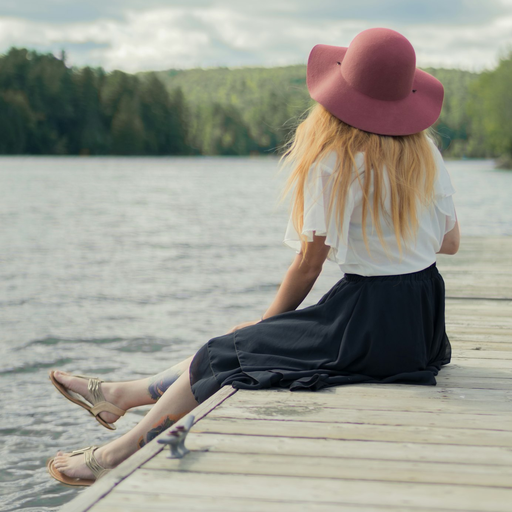

In [ ]:
target_width, target_height = 512,512 # if you have memory issues, reduce even more the target size
source_image = Image.open('image.jpg')

width, height = source_image.size
print(f"Source image size: {source_image.size}")

# We make the image square
source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)

# We resize the image to the target dimensions (so that it uses less memory)
source_image = source_image.resize((target_width, target_height), Image.LANCZOS )
print(f"Target image size: {source_image.size}")

### we convert the image into an array in order to use it later with the segmentation model
segmentation_image = asarray(source_image)

display(source_image)



In [ ]:
### Initialize Segment Anything Model

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

### Pay attention to the pred_iou_thresh, the lower the more masks it will generate. Make it higher to generate masks only of
### good quality and less number of them
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.99, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
### Run Segmentation Model
masks = mask_generator.generate(segmentation_image)

### Print number of masks generated and the keys attached to each of them
print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

# Intersection Over Union (IoU) tell us the degree of overlap between two boxes.
# In the case of object detection and segmentation, it refers to the overlap of the Ground Truth and Prediction region


Number of masks generated: 10
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
### Declare function to visualize the masks generated together with a number that identifies each of them

def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')



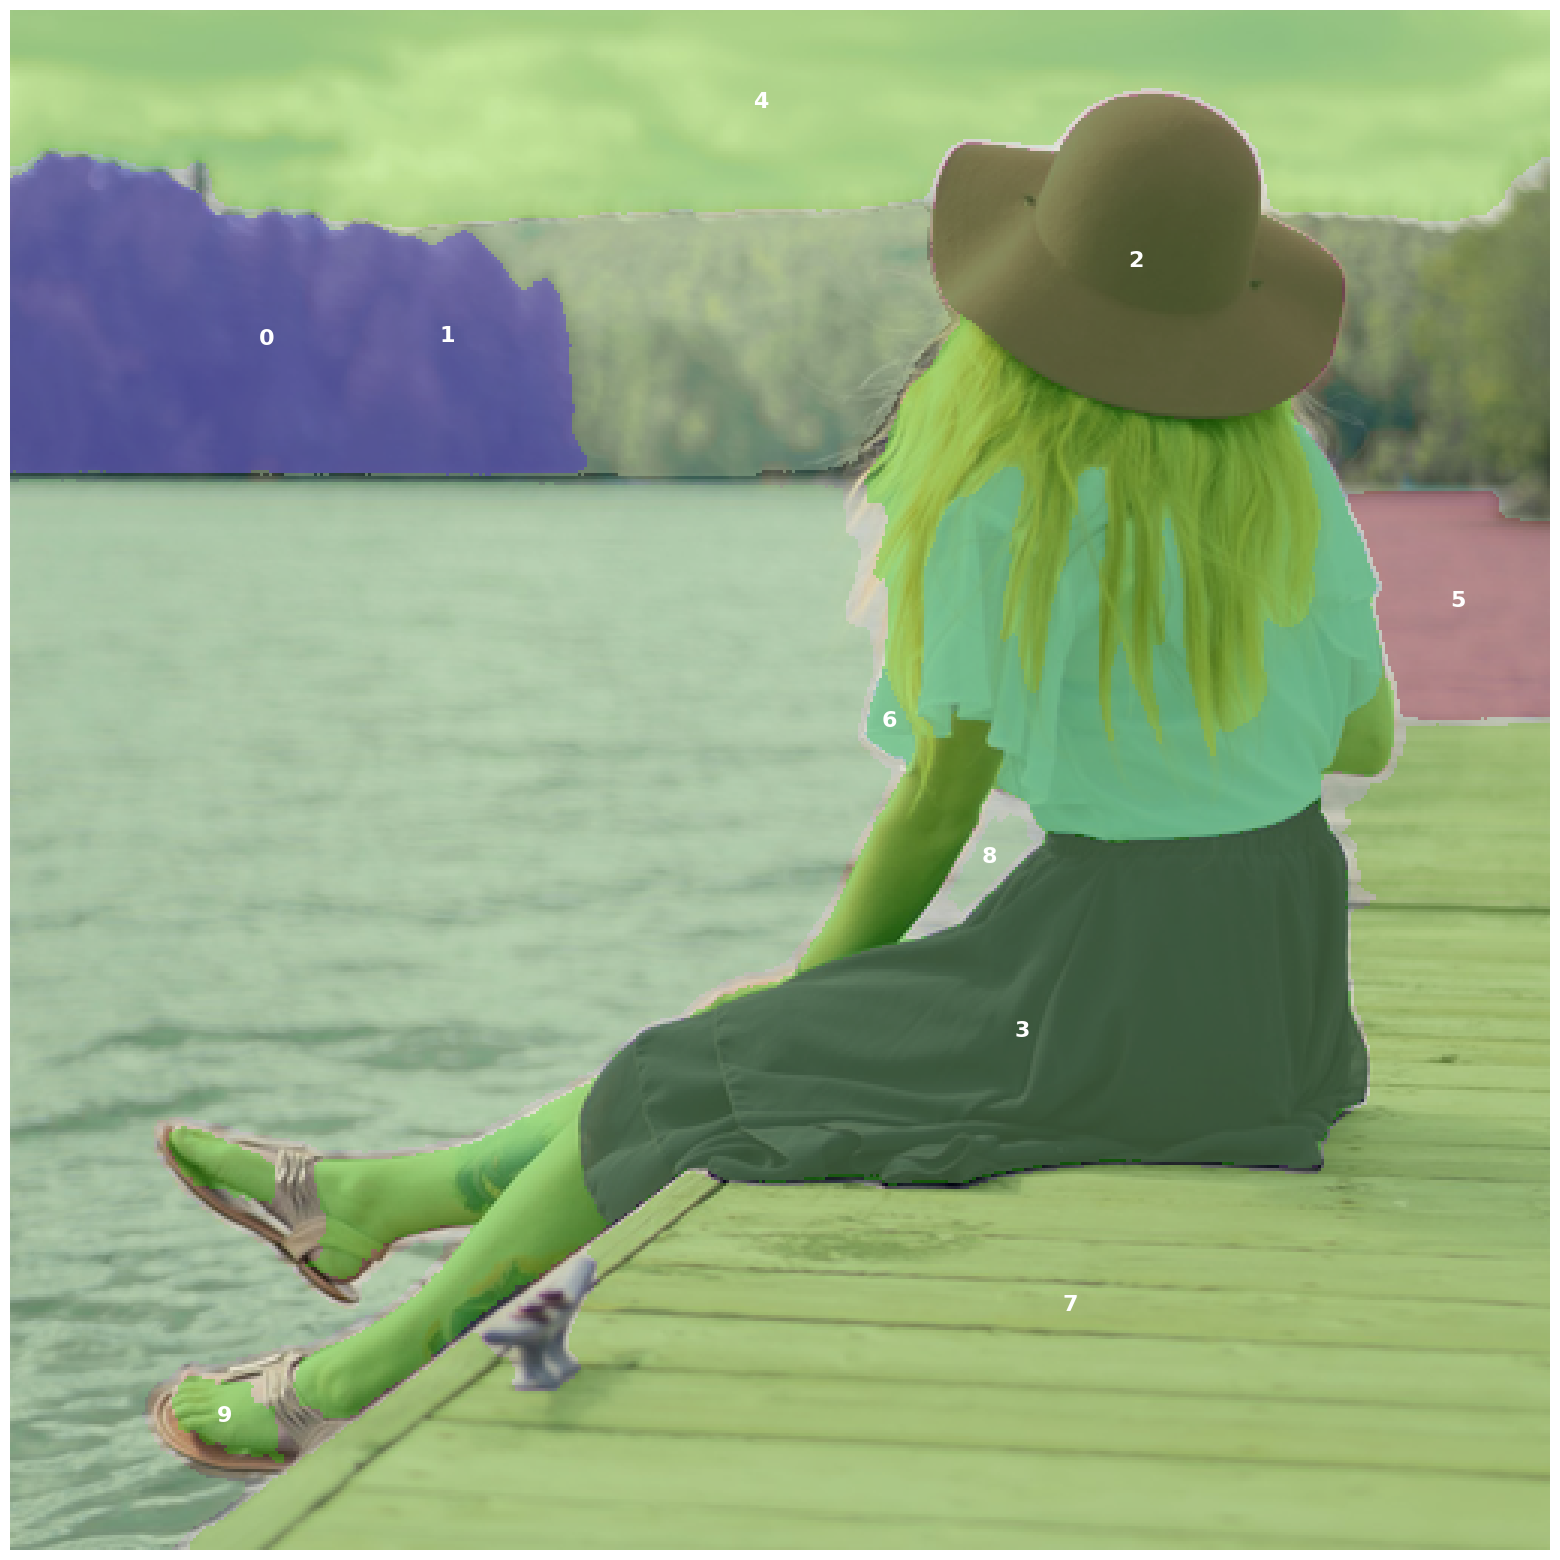

In [ ]:
### Display Masks with a number identifying each of them

plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)  # use masks[:-x] to only display the first masks of the list
plt.axis('off')
plt.show()

In [ ]:

for i, values in enumerate(masks):
   print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")



0: Area: 16106 | IoU: 0.9994584321975708
1: Area: 26573 | IoU: 0.9990361928939819
2: Area: 10630 | IoU: 1.018379807472229
3: Area: 21822 | IoU: 1.0152678489685059
4: Area: 29820 | IoU: 1.009849190711975
5: Area: 4159 | IoU: 1.0027542114257812
6: Area: 10400 | IoU: 0.9930732250213623
7: Area: 54665 | IoU: 1.0228735208511353
8: Area: 66722 | IoU: 1.013566255569458
9: Area: 63229 | IoU: 1.0082385540008545


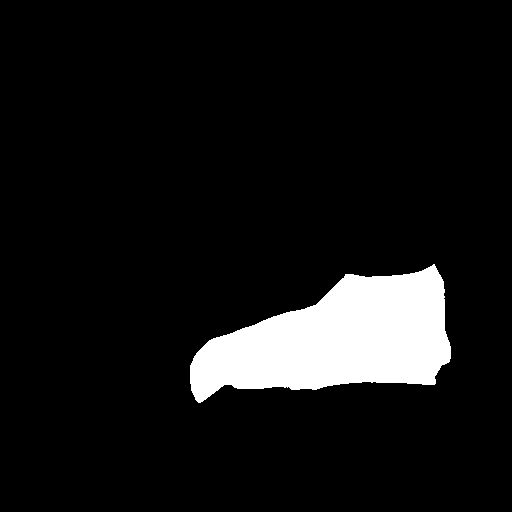

In [69]:
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 3
mask_index = 3

segmentation_mask=masks[mask_index]['segmentation']
stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)

In [73]:
### Setup transformation prompts
num_images_per_prompt = 4
inpainting_prompts = [
    "skirt made of cascading layers of iridescent fabric, shimmering like a rainbow",
    "skirt adorned with intricate lace patterns resembling a blooming garden",
     "skirt crafted from seashells",
    "skirt designed with a galaxy theme, featuring realistic stars and swirling nebulae"
]
generator = torch.Generator(device="cuda")

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=10, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [74]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


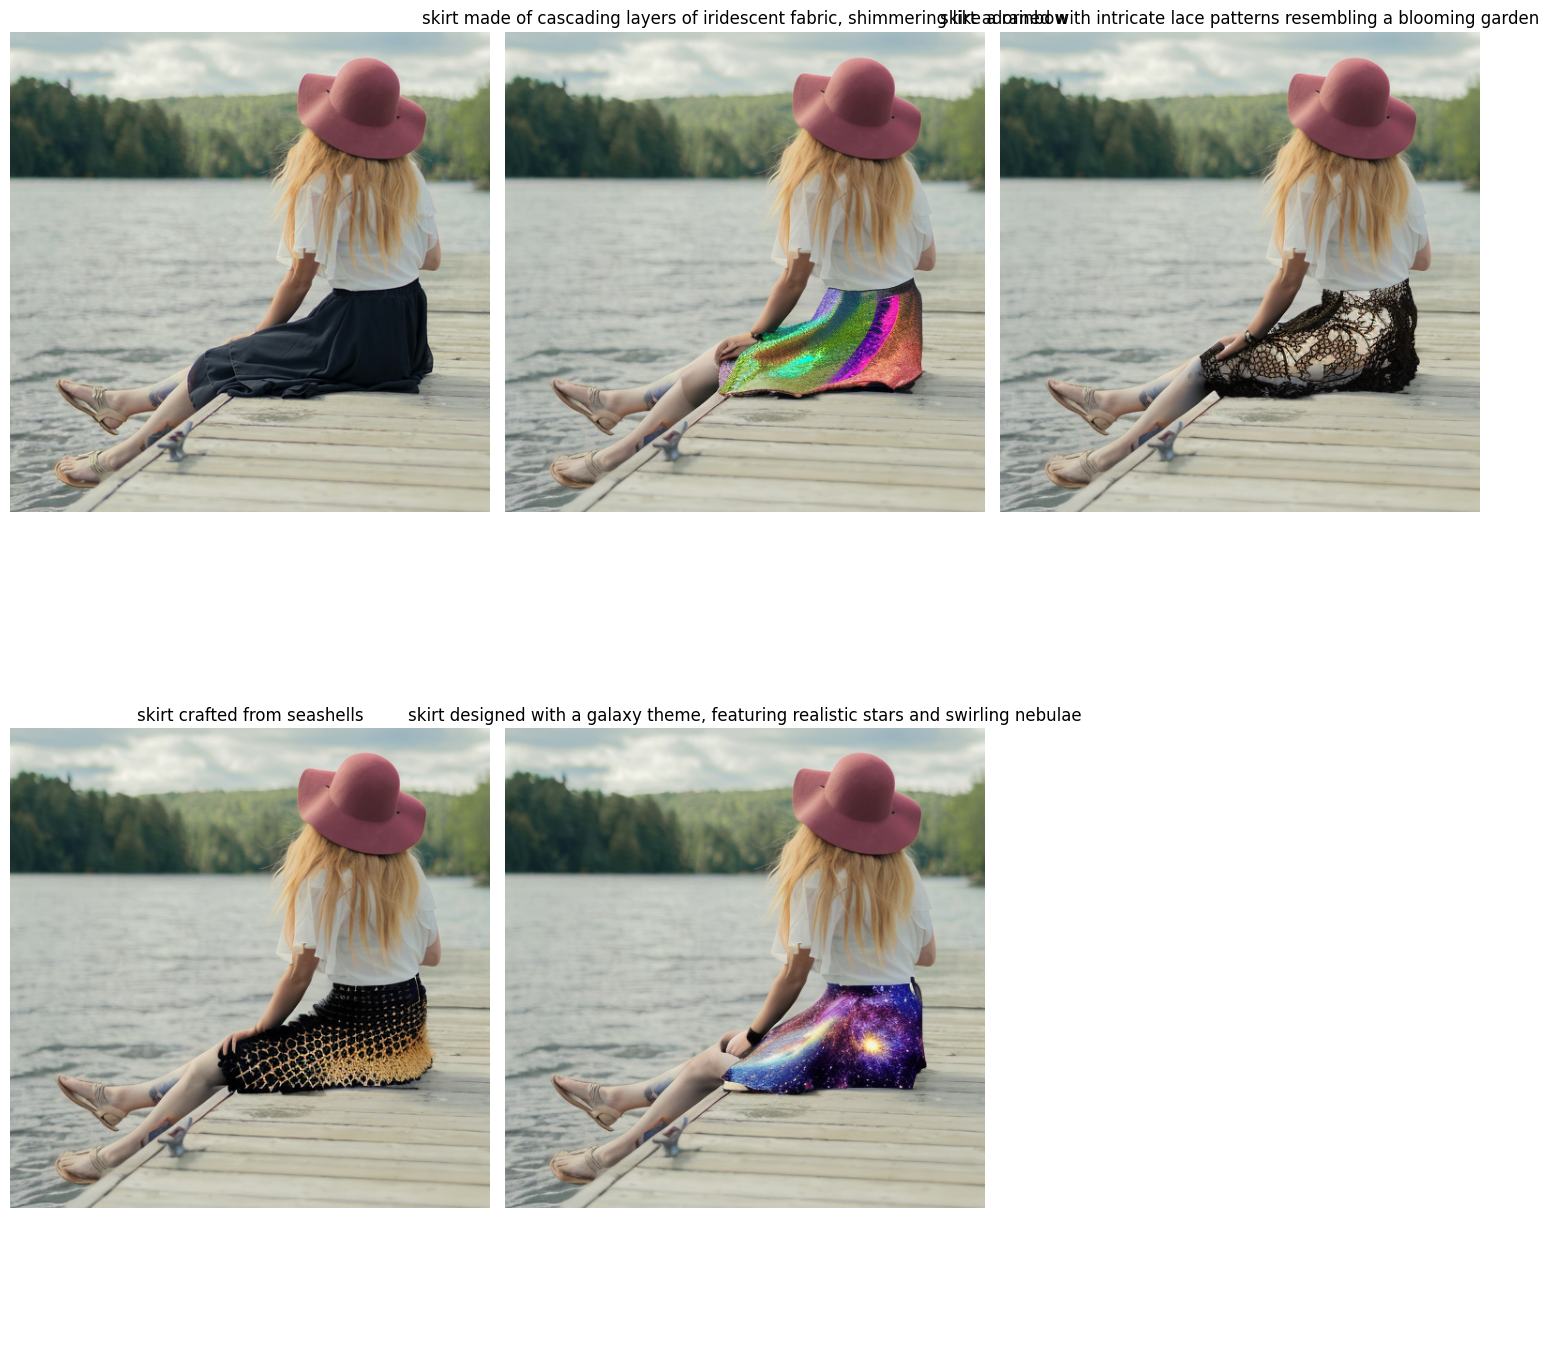

In [75]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)